In [93]:
!pip install -Uqq fastbook

In [94]:
from fastbook import *
from fastai.vision.widgets import *

To download images with Bing Image Search, sign up at Microsoft Azure, Create a search service. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [95]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxxxxx')

In [96]:
beagle_dog_results = search_images_bing(key, 'beagle dog')
beagle_dog_image_urls = beagle_dog_results.attrgot('content_url')
len(beagle_dog_image_urls)

150

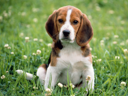

In [97]:
dest = 'images/beagle2.jpg'
download_url(beagle_dog_image_urls[0], dest)

beagle_image = Image.open(dest)
beagle_image.to_thumb(128,128)

In [98]:
dog_types = 'beagle','dobar man','dolmation'
dogs_path = Path('dogs')
if not dogs_path.exists():
    dogs_path.mkdir()
    for d in dog_types:
        dog_dest = (dogs_path/d)
        dog_dest.mkdir(exist_ok=True)
        dog_results = search_images_bing(key, f'{d} dog')
        download_images(dog_dest, urls=dog_results.attrgot('content_url'))

dog_files = get_image_files(dogs_path)
dog_files

(#439) [Path('dogs/beagle/00000000.jpg'),Path('dogs/beagle/00000001.jpg'),Path('dogs/beagle/00000002.jpeg'),Path('dogs/beagle/00000003.jpg'),Path('dogs/beagle/00000004.jpg'),Path('dogs/beagle/00000006.jpg'),Path('dogs/beagle/00000007.jpeg'),Path('dogs/beagle/00000008.jpg'),Path('dogs/beagle/00000009.jpeg'),Path('dogs/beagle/00000010.jpg')...]

In [99]:
failed_dog_downloads = verify_images(dog_files)
print(f'There are {len(failed_dog_downloads)} failed dog downloads')
# TODO We get an error when we run the bellow unlink script more than once.
# Put a check to call the Path.unlink only if the image is not unlinked yet
# if len(failed_dog_downloads):
#     failed_dog_downloads.map(Path.unlink)

failed_dog_downloads

There are 0 failed dog downloads


(#0) []

In [100]:
# Creating a data block
dogs_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [101]:
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)

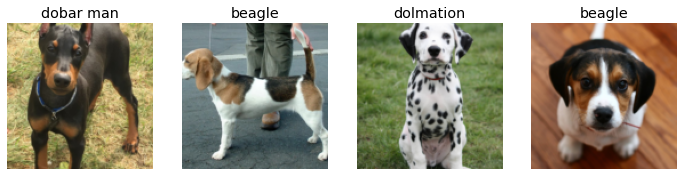

In [102]:
# See samples from validation set
dog_data_loaders.valid.show_batch(max_n=4, nrows=1)

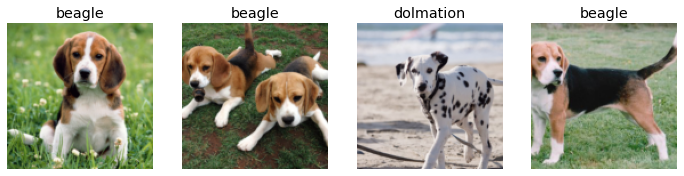

In [103]:
# See samples from training set
dog_data_loaders.train.show_batch(max_n=4, nrows=1)

In [104]:
# By default Resize crops the images to fit a square shape of the size requested,
# using the full width or height. This can result in losing some important details.
# Alternatively, you can ask fastai to pad the images with zeros (black),
# or squish/stretch them:

dogs_data_block = dogs_data_block.new(item_tfms=Resize(128, ResizeMethod.Squish))
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)


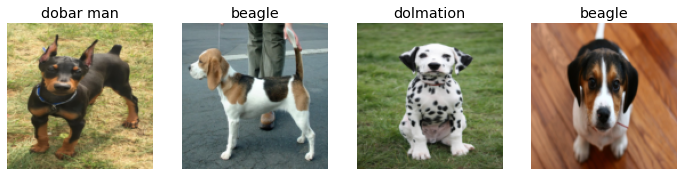

In [105]:
# Sample images from Validation set after resizing
dog_data_loaders.valid.show_batch(max_n=4, nrows=1)

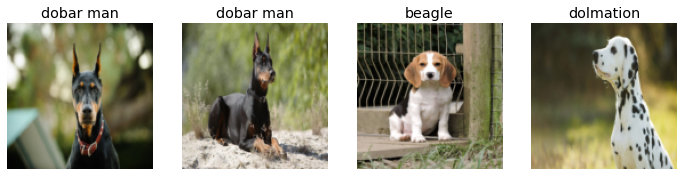

In [106]:
# Sample images from Training set after resizing
dog_data_loaders.train.show_batch(max_n=4, nrows=1)

In [107]:
dogs_data_block = dogs_data_block.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)

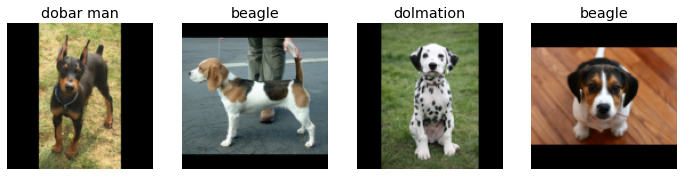

In [108]:
# Sample images from Validation set after applying black padding 
dog_data_loaders.valid.show_batch(max_n=4, nrows=1)

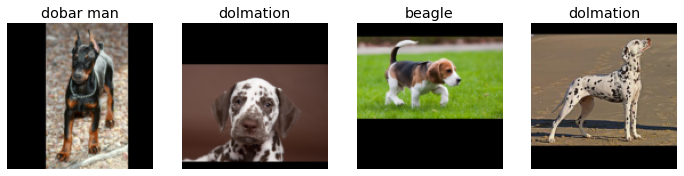

In [109]:
# Sample images from Training set after applying black padding 
dog_data_loaders.train.show_batch(max_n=4, nrows=1)

In [110]:
# Applying crop method instead of resize method
dogs_data_block = dogs_data_block.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)

# This method is using Data augmentation. Random variations of each image would be created

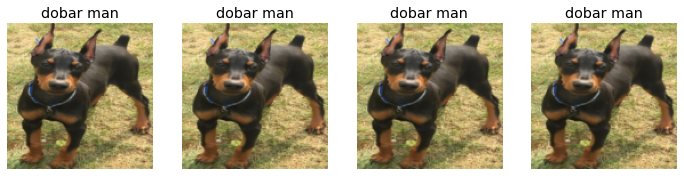

In [111]:
# Sample images from Validation set after applying crop
dog_data_loaders.valid.show_batch(max_n=4, nrows=1, unique=True)

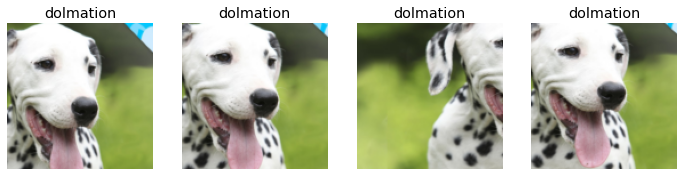

In [112]:
# Sample images from Training set after applying crop
dog_data_loaders.train.show_batch(max_n=4, nrows=1, unique=True)

In [113]:
# Data augmentation beyond default
dogs_data_block = dogs_data_block.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)

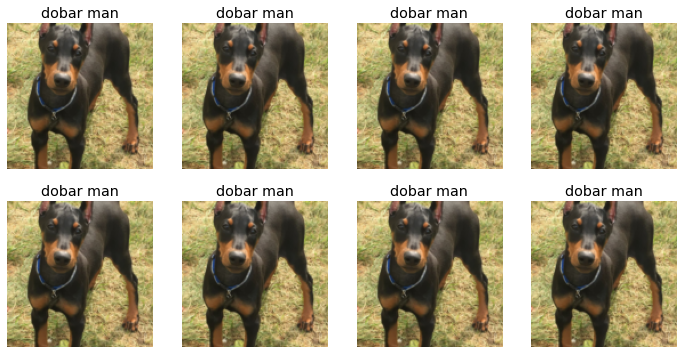

In [114]:
# Sample Image augmented variations of Validation Data Set
dog_data_loaders.valid.show_batch(max_n=8, nrows=2, unique=True)

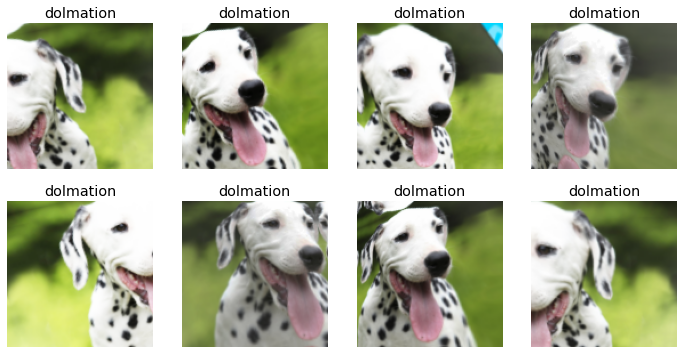

In [115]:
# Sample Image augmented variations of Training Data Set
dog_data_loaders.train.show_batch(max_n=8, nrows=2, unique=True)

# Training Your Model, and Using It to Clean Your Data¶
Time to use the same lines of code as in <

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [116]:
dogs_data_block = dogs_data_block.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dog_data_loaders = dogs_data_block.dataloaders(dogs_path)


We can now create our Learner and fine-tune it in the usual way:

In [117]:
learn = cnn_learner(dog_data_loaders, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.391762,0.021084,0.000000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.083034,0.001176,0.000000,00:08
1,0.063530,0.000213,0.000000,00:09
2,0.042037,0.000162,0.000000,00:09
3,0.030211,0.000244,0.000000,00:09


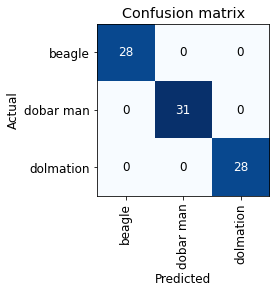

In [118]:
# Creating confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [119]:
# Exporting Model
# When you call export, by default, fastai will save a file called "export.pkl"
# We are passing file name here
learn.export(fname='dog_learner.pkl')

Let's check that the file exists, by using the ls method that fastai adds to Python's Path class:


In [120]:
learner_path = Path()
learner_path.ls(file_exts='.pkl')

(#2) [Path('dog_learner.pkl'),Path('export.pkl')]

In [121]:
file = open('dog_learner.pkl') 
file

<_io.TextIOWrapper name='dog_learner.pkl' mode='r' encoding='UTF-8'>

In [122]:
Path('dog_learner.pkl').stat()

os.stat_result(st_mode=33188, st_ino=281019490, st_dev=64768, st_nlink=1, st_uid=0, st_gid=0, st_size=47016310, st_atime=1600526661, st_mtime=1600531045, st_ctime=1600531045)

In [123]:
bytes = Path('dog_learner.pkl').stat().st_size
mega_bytes = 0.000001 * bytes
print(f'Model size = {round(mega_bytes)} MB')

Model size = 47 MB


# Using the trained model

In [124]:
# We can use the 'learn' object from above. But to demostrate the flow, 
# we are loading the model
learn_inference = load_learner(learner_path/'dog_learner.pkl')

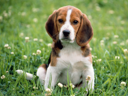

In [125]:
# Test input - We had downloaded this in the beginning
dest = 'images/beagle2.jpg'
# download_url(beagle_dog_image_urls[0], dest)

# beagle_image = Image.open(dest)
beagle_image.to_thumb(128,128)

In [126]:
dog_prediction = learn_inference.predict('images/beagle2.jpg')
dog_prediction

('beagle', tensor(0), tensor([9.9998e-01, 1.0546e-06, 1.5676e-05]))

In [127]:
dog_prediction[0]

'beagle'

In [128]:
learn_inference.dls.vocab

(#3) ['beagle','dobar man','dolmation']

# Creating a Web Application to serve the Learner(Model)

In [129]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [134]:
btn_upload.data

[]

In [133]:
if len(btn_upload.data) > 0:
    uploaded_dog_image = PILImage.create(btn_upload.data[-1])
    uploaded_dog_image

In [ ]:
# Use output widget to display
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(uploaded_dog_image.to_thumb(128,128))
out_pl

In [ ]:
# Predicting...
prediction,prediction_idx,probabilities = learn_inference.predict(uploaded_dog_image)

In [135]:
# Use Label to display
label_prediction = widgets.Label()
label_prediction.value = f'Prediction: {prediction}; Probability: {probabilities[prediction_idx]:.04f}'
label_prediction

Label(value='Prediction: beagle; Probability: 1.0000')

In [136]:
# We'll need a button to do the classification. It looks exactly like the upload button:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [137]:
# We'll also need a click event handler;
# that is, a function that will be called when it's pressed.
# We can just copy over the lines of code from above:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inference.predict(img)
    label_prediction.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [138]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()
VBox([
    widgets.Label('Select your bear!'),
    btn_upload,
    btn_run,
    out_pl,
    label_prediction
])